#### Install necessary packages

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%%capture
!unzip /content/gdrive/MyDrive/archive.zip -d /content/training-dataset/

In [4]:
%%capture
!unzip /content/gdrive/MyDrive/test-archive.zip -d /content/testing-dataset

In [5]:
!mv "/content/testing-dataset/development_test_data/gallery" "/content/"
!mv "/content/testing-dataset/development_test_data/queries" "/content/"

!mkdir "/content/original_datasets"
!mv "/content/testing-dataset/development_test_data/gallery.csv" "/content/original_datasets/"
!mv "/content/testing-dataset/development_test_data/queries.csv" "/content/original_datasets/"

!rm -rf "/content/testing-dataset"

!mv "/content/training-dataset/train.csv" "/content/original_datasets/"
!mv "/content/training-dataset/test.csv" "/content/original_datasets/"

!mkdir "/content/train_imgs"

mv: cannot stat '/content/training-dataset/train.csv': No such file or directory


In [7]:
import os
import shutil

train_images = [f for f in os.listdir('/content/training-dataset/train/train')]
for image in train_images:
  shutil.move('/content/training-dataset/train/train/' + image, '/content/train_imgs/' + image)

test_images = [f for f in os.listdir('/content/training-dataset/test/test')]
for image in test_images:
  shutil.move('/content/training-dataset/test/test/' + image, '/content/train_imgs/' + image)

In [64]:
!rm -rf "/content/training-dataset"

In [8]:
!mkdir "/content/generated_datasets"
!cp '/content/gdrive/MyDrive/train_dataset.csv' '/content/generated_datasets/'
!cp '/content/gdrive/MyDrive/train_tensors.csv' '/content/generated_datasets/'

In [9]:
%%capture
!unzip "/content/gdrive/MyDrive/gallery_tensors.zip"
!mv 'content/gallery_tensors' '/content/'

In [10]:
%%capture
!unzip "/content/gdrive/MyDrive/query_tensors.zip"
!mv 'content/query_tensors' '/content/'

In [11]:
%%capture
!unzip "/content/gdrive/MyDrive/query_tensors_cropped.zip"
!mv 'content/query_tensors_cropped' '/content/'

In [16]:
!rm -rf "content"

In [17]:
%%capture
!unzip "/content/gdrive/MyDrive/train_imgs_tensors.zip"

#### Imports

#### Some useful commands

In [18]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, Dinov2Model
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms.functional as F
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [19]:
# use this command to see the available RAM space
!free -g

               total        used        free      shared  buff/cache   available
Mem:              12           1           0           0          10          10
Swap:              0           0           0


In [20]:
# clear the GPU memory cache and free-up GPU memory
torch.cuda.empty_cache()

## The file and folder structure of data for model building
```
File and folder structure of Product-10K dataset

content
└───gallery
|   |   ambitious-tough-teal-from-asgard.jpg
|   |   fine-shrewd-oarfish-of-genius.jpg
|   |   bold-nickel-gecko-of-reputation.jpg
|   |   marvellous-uber-boobook-of-lightning.jpg
|   |   bouncy-economic-agama-of-honeydew.jpg
│   
└───queries
|   |   magnetic-powerful-platypus-of-hail.jpeg
|   |   free-keen-mole-of-cookies.jpeg
|   |   optimal-uptight-ringtail-of-cleaning.jpeg
|   |   bold-nickel-gecko-of-reputation.jpg
|   |   marvellous-uber-boobook-of-lightning.jpg
|
└───train_imgs
|   |   1.jpg
|   |   10.jpg
|   |   100.jpg
|   |   1000.jpg
|
└───original_datasets
|   |   gallery.csv
|   |   queries.csv
|   |   train.csv
|   |   test.csv
|
└───generated_datasets
|   |   train_dataset.csv
|
```

In [21]:
model_ckpt = "facebook/dinov2-giant"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt,
                                                     do_normalize=True,
                                                     do_center_crop=True,
                                                     do_rescale=True,
                                                     do_resize=True,
                                                     size={'shortest_edge': 384},
                                                     crop_size={'height':384, 'width':384})
model = Dinov2Model.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

In [22]:
model

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-39): 40 x Dinov2Layer(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1536, out_features=1536, bias=True)
            (key): Linear(in_features=1536, out_features=1536, bias=True)
            (value): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_

In [23]:
image_processor

BitImageProcessor {
  "crop_size": {
    "height": 384,
    "width": 384
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  },
  "use_square_size": false
}

In [24]:
model = model.to('cuda')

In [25]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, indices, transform=None, target_transform=None, crop_to_bbox=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.indices = indices
        self.transform = transform
        self.target_transform = target_transform
        self.crop_to_bbox = crop_to_bbox

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, self.indices[0]])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, self.indices[1]]
        if self.transform:
            if not self.crop_to_bbox:
              image = self.transform(image)
            else:
              x = self.img_labels.iloc[idx, self.indices[2]]
              y = self.img_labels.iloc[idx, self.indices[3]]
              w = self.img_labels.iloc[idx, self.indices[4]]
              h = self.img_labels.iloc[idx, self.indices[5]]
              image = self.transform(image, x, y, w, h)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path

def image_transformation(image):
    images = F.resize(image, (384, 384), antialias=True)
    images = image_processor(images, return_tensors="pt")
    return images

def image_transform_with_bbox_crop(image, x, y, w, h):
    images = F.crop(image, y, x, h, w)
    images = F.resize(images, (384, 384), antialias=True)
    images = image_processor(images, return_tensors="pt")
    return images

In [26]:
gallery = pd.read_csv("original_datasets/gallery.csv")
gallery.head()

,seller_img_id,img_path,product_id
0,0,gallery/ambitious-tough-teal-from-asgard.jpg,5019
1,1,gallery/fine-shrewd-oarfish-of-genius.jpg,5008
2,2,gallery/bold-nickel-gecko-of-reputation.jpg,9
3,3,gallery/marvellous-uber-boobook-of-lightning.jpg,3589
4,4,gallery/bouncy-economic-agama-of-honeydew.jpg,3656


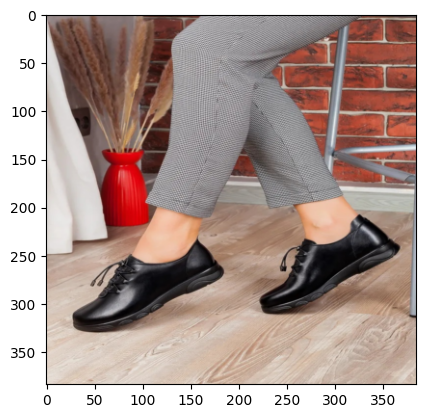

In [27]:
# test image preprocessing
proc = AutoImageProcessor.from_pretrained(model_ckpt,
                                          do_normalize=True,
                                          do_center_crop=True,
                                          do_rescale=True,
                                          do_resize=True,
                                          size={'shortest_edge': 384},
                                          crop_size={'height':384, 'width':384})
img = read_image(gallery.iloc[0, 1])
img_ = F.to_pil_image(F.resize(img, (384, 384), antialias=True))
plt.imshow(np.asarray(img_))

torch.Size([3, 384, 384])


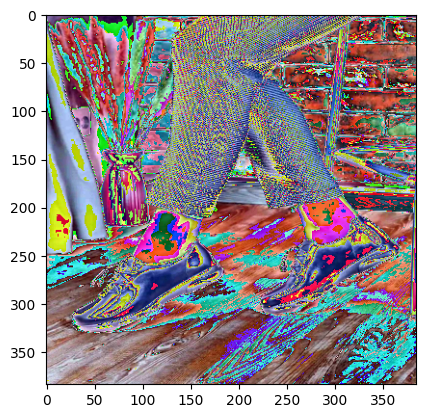

In [28]:
proc_img = proc(img_, return_tensors="pt")
proc_img = torch.squeeze(proc_img['pixel_values'], dim=0)
print(proc_img.shape)
proc_img = F.to_pil_image(proc_img)
plt.imshow(np.asarray(proc_img))

### Generate embeddings for gallery images and save

In [31]:
gallery_dataset = CustomDataset("original_datasets/gallery.csv", "", [1, 2], transform=image_transformation)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=32, shuffle=True)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("gallery_tensors"):
    os.makedirs("gallery_tensors")

for idx, data in enumerate(tqdm(gallery_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'gallery_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('gallery_tensors/gallery_tensors.csv', index=False)

100%|██████████| 34/34 [10:32<00:00, 18.60s/it]


In [32]:
class TensorDataset(Dataset):
    def __init__(self, annotations_file, tensor_dir, transform=None, target_transform=None):
        self.tensor_labels = pd.read_csv(annotations_file)
        self.tensor_dir = tensor_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.tensor_labels)

    def __getitem__(self, idx):
        tensor_path = os.path.join(self.tensor_dir, self.tensor_labels.iloc[idx, 1])
        tensor = torch.load(tensor_path)
        label = self.tensor_labels.iloc[idx, 2]
        image_path = self.tensor_labels.iloc[idx, 3]
        if self.transform:
            tensor = self.transform(tensor)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor, label, image_path

In [33]:
gallery_tensors = pd.read_csv("gallery_tensors/gallery_tensors.csv")
gallery_tensors.head()

,index,tensor_path,label,image_path
0,0,gallery_tensors/0_0.pt,3532,gallery/uncovered-nonchalant-mongoose-of-memor...
1,1,gallery_tensors/0_1.pt,3504,gallery/impossible-artichoke-wolf-from-eldorad...
2,2,gallery_tensors/0_2.pt,5073,gallery/calm-interesting-cobra-of-whirlwind.jpg
3,3,gallery_tensors/0_3.pt,3637,gallery/competent-devious-perch-of-love.jpg
4,4,gallery_tensors/0_4.pt,5024,gallery/stalwart-orchid-mastodon-of-perspectiv...


In [34]:
tensor_dataset = TensorDataset("gallery_tensors/gallery_tensors.csv", "")
tensor_dataloader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

tensor_dict = {}
label_dict = {}
image_path_dict = {}

for idx, data in enumerate(tqdm(tensor_dataloader)):
    tensors, labels, image_paths = data
    tensor_dict[idx] = tensors
    label_dict[idx] = labels
    image_path_dict[idx] = image_paths

100%|██████████| 34/34 [00:00<00:00, 74.13it/s]


In [35]:
query = pd.read_csv("original_datasets/queries.csv")
query.head()

,user_img_id,img_path,bbox_x,bbox_y,bbox_w,bbox_h,product_id
0,0,queries/magnetic-powerful-platypus-of-hail.jpeg,0,212,740,664,5013
1,1,queries/free-keen-mole-of-cookies.jpeg,0,43,714,378,3550
2,2,queries/hilarious-precious-parakeet-of-adverti...,240,310,395,405,71
3,3,queries/optimal-uptight-ringtail-of-cleaning.jpeg,0,242,475,627,3566
4,4,queries/nonchalant-impala-of-fabulous-artistry...,350,125,150,81,5329


### Generate embeddings for query images(without cropping to bounding box) and save

In [36]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6], transform=image_transformation)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors"):
    os.makedirs("query_tensors")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors/query_tensors.csv', index=False)

100%|██████████| 61/61 [19:08<00:00, 18.83s/it]


In [37]:
query_tensors = pd.read_csv("query_tensors/query_tensors.csv")
query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


### Generate embeddings for query images(with cropping to bounding box) and save

In [38]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6, 2, 3, 4, 5], transform=image_transform_with_bbox_crop, crop_to_bbox=True)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors_cropped"):
    os.makedirs("query_tensors_cropped")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors_cropped/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors_cropped/query_tensors.csv', index=False)

100%|██████████| 61/61 [18:55<00:00, 18.61s/it]


In [39]:
cropped_query_tensors = pd.read_csv("query_tensors_cropped/query_tensors.csv")
cropped_query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors_cropped/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors_cropped/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors_cropped/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors_cropped/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors_cropped/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


### Load the saved query image embedding tensors(non-cropped)

In [40]:
query_tensor_dataset = TensorDataset("query_tensors/query_tensors.csv", "")
query_tensor_dataloader = DataLoader(query_tensor_dataset, batch_size=1, shuffle=False)

query_tensor_dict = {}
query_label_dict = {}
query_image_path_dict = {}

for idx, data in enumerate(tqdm(query_tensor_dataloader)):
    tensors, labels, image_paths = data
    query_tensor_dict[idx] = tensors
    query_label_dict[idx] = labels
    query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:01<00:00, 1289.39it/s]


### Load the saved query image embedding tensors(cropped)

In [41]:
crop_query_tensor_dataset = TensorDataset("query_tensors_cropped/query_tensors.csv", "")
crop_query_tensor_dataloader = DataLoader(crop_query_tensor_dataset, batch_size=1, shuffle=False)

crop_query_tensor_dict = {}
crop_query_label_dict = {}
crop_query_image_path_dict = {}

for idx, data in enumerate(tqdm(crop_query_tensor_dataloader)):
    tensors, labels, image_paths = data
    crop_query_tensor_dict[idx] = tensors
    crop_query_label_dict[idx] = labels
    crop_query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:01<00:00, 1275.28it/s]


In [42]:
batch_size = 32

def AP(actual_label, predicted_labels):
    GPTs = predicted_labels.count(actual_label)
    if GPTs < 1:
        return 1
    AP = 0
    GPTs_found = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == actual_label:
            GPTs_found += 1
            AP += GPTs_found / (i + 1)
    return AP / GPTs

def mAP(APs):
    return np.average(APs)

def zero_shot_model(query_tensor_dictionary, query_label_dictionary):
    APs_euclidean = []
    APs_manhattan = []
    APs_cosine = []
    for i in tqdm(range(len(query_tensor_dictionary))):
        query_tensor_ = query_tensor_dictionary[i].to('cuda')
        query_tensor = query_tensor_.repeat(batch_size, 1)

        euclidean = None
        manhattan = None
        cosine = None
        pred_labels = None
        act_label = query_label_dictionary[i]
        for k in range(len(tensor_dict)):
            if tensor_dict[k].shape[0] < batch_size:
                query_tensor = query_tensor_.repeat(tensor_dict[k].shape[0], 1)
            gallery_tensors = tensor_dict[k].to('cuda')
            gallery_labels = label_dict[k].to('cuda')
            if euclidean == None and manhattan == None and cosine == None:
                euclidean = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)
                manhattan = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)
                cosine = torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)
                pred_labels = gallery_labels
            else:
                euclidean = torch.cat((euclidean, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)), dim=0)
                manhattan = torch.cat((manhattan, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)), dim=0)
                cosine = torch.cat((cosine, torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)), dim=0)
                pred_labels = torch.cat((pred_labels, gallery_labels), dim=0)

        euclidean_, euclidean_indices = torch.sort(euclidean)
        manhattan_, manhattan_indices = torch.sort(manhattan)
        cosine_, cosine_indices = torch.sort(torch.abs(cosine), descending=True)

        pred_labels_euclidean = pred_labels[euclidean_indices]
        pred_labels_manhattan = pred_labels[manhattan_indices]
        pred_labels_cosine = pred_labels[cosine_indices]

        APs_euclidean.append(AP(act_label.item(), pred_labels_euclidean.cpu().numpy().astype(int).tolist()))
        APs_manhattan.append(AP(act_label.item(), pred_labels_manhattan.cpu().numpy().astype(int).tolist()))
        APs_cosine.append(AP(act_label.item(), pred_labels_cosine.cpu().numpy().astype(int).tolist()))

    print('\nEuclidean distance mAP:', mAP(APs_euclidean))
    print('Manhattan distance mAP:', mAP(APs_manhattan))
    print('Cosine distance mAP:', mAP(APs_cosine))

In [43]:
zero_shot_model(query_tensor_dict, query_label_dict)

100%|██████████| 1935/1935 [00:32<00:00, 59.37it/s]


Euclidean distance mAP: 0.17185101378022843
Manhattan distance mAP: 0.17271334407061173
Cosine distance mAP: 0.173738855043641


In [44]:
zero_shot_model(crop_query_tensor_dict, crop_query_label_dict)

100%|██████████| 1935/1935 [00:31<00:00, 60.57it/s]


Euclidean distance mAP: 0.1804611131753123
Manhattan distance mAP: 0.1816061545593802
Cosine distance mAP: 0.18208757129645387


### Save the embeddings for future use as Zip

In [45]:
%%capture
!zip -r gallery_tensors_dino_v2.zip '/content/gallery_tensors/'

In [46]:
%%capture
!zip -r query_tensors_dino_v2.zip '/content/query_tensors/'

In [47]:
%%capture
!zip -r query_tensors_cropped_dino_v2.zip '/content/query_tensors_cropped/'

In [48]:
!cp '/content/gallery_tensors_dino_v2.zip' '/content/gdrive/MyDrive/gallery_tensors_dino_v2.zip'
!cp '/content/query_tensors_dino_v2.zip' '/content/gdrive/MyDrive/query_tensors_dino_v2.zip'
!cp '/content/query_tensors_cropped_dino_v2.zip' '/content/gdrive/MyDrive/query_tensors_cropped_dino_v2.zip'

# Now let's train a model with only one linear layer

In [43]:
# train_dataset = pd.read_csv('/content/generated_datasets/train_dataset.csv', low_memory=False)
# print(train_dataset.shape)
# display(train_dataset.head())

In [44]:
# list_of_images = train_dataset['img1'].unique().tolist() + train_dataset['img2'].unique().tolist()
# unique_images_list = list(set(list_of_images))
# print("Count of unique images:", len(unique_images_list))
# print(unique_images_list[0:10])

In [45]:
# import os
# from torch.utils.data import Dataset
# from torchvision.io import read_image
# import torchvision.transforms as T
# import torchvision.transforms.functional as F

# class CustomTrainDataset(Dataset):
#     def __init__(self, image_paths, img_dir, transform=None):
#         self.img_paths = image_paths
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_paths[idx])
#         image = read_image(img_path)
#         if self.transform:
#             image = self.transform(image)
#         return image, self.img_paths[idx], img_path

# def image_transformation(image):
#     images = F.resize(image, (384, 384), antialias=True)
#     images = image_processor(images, return_tensors="pt")
#     return images

# from tqdm import tqdm
# from torch.utils.data import DataLoader

# train_image_dataset = CustomTrainDataset(unique_images_list, "/content/train_imgs", transform=image_transformation)
# train_image_dataloader = DataLoader(train_image_dataset, batch_size=32, shuffle=True)

# df = pd.DataFrame(columns=['tensor_path', 'img_name', 'image_path'])

# if not os.path.exists("train_imgs_tensors"):
#     os.makedirs("train_imgs_tensors")

# for idx, data in enumerate(tqdm(train_image_dataloader)):
#     images, img_names, img_paths = data
#     images = images['pixel_values'].to('cuda')
#     images = torch.squeeze(images, dim=1)

#     with torch.no_grad():
#         output = model(images)
#         embeddings = output.last_hidden_state[:, 0].cpu()

#     for i in range(embeddings.shape[0]):
#         file_path = f'train_imgs_tensors/{idx}_{i}.pt'
#         torch.save(embeddings[i], file_path)
#         df.loc[len(df)] = [file_path, img_names[i], img_paths[i]]

# df.reset_index(inplace = True)
# df.to_csv('train_imgs_tensors/train_imgs_tensors.csv', index=False)

In [46]:
# df = train_dataset.copy()
# df['tensor1'] = np.nan
# df['tensor2'] = np.nan

# train_imgs_tensors_dataset = pd.read_csv('train_imgs_tensors/train_imgs_tensors.csv', low_memory=False)

# for index, row in tqdm(train_imgs_tensors_dataset.iterrows()):
#   df.loc[df['img1'] == row['img_name'], 'tensor1'] = row['tensor_path']
#   df.loc[df['img2'] == row['img_name'], 'tensor2'] = row['tensor_path']

# list_of_tensors = df['tensor1'].unique().tolist() + df['tensor2'].unique().tolist()
# unique_tensor_list = list(set(list_of_tensors))
# print("Count of unique images:", len(unique_tensor_list))
# print(unique_tensor_list[0:10])

# null_count = df.isnull().sum().sum()
# print('Number of null values:', null_count)

# df.reset_index(inplace = True)
# df.to_csv('train_imgs_tensors/train_tensors.csv', index=False)

In [47]:
# train_tensors_dataset_ = pd.read_csv('train_imgs_tensors/train_tensors.csv', low_memory=False)
# train_tensors_dataset_.reset_index(drop=True, inplace = True)
# train_tensors_dataset_.drop(['index', 'Unnamed: 0'], inplace=True, axis=1)
# train_tensors_dataset_.to_csv('generated_datasets/train_tensors.csv', index=False)

In [49]:
train_tensors_dataset_ = pd.read_csv('generated_datasets/train_tensors.csv', low_memory=False)
train_tensors_dataset_.head()

,img1,img2,label,tensor1,tensor2
0,14346.jpg,7211589.jpg,0,train_imgs_tensors/3815_25.pt,train_imgs_tensors/3443_0.pt
1,77676.jpg,1671857.jpg,0,train_imgs_tensors/3400_25.pt,train_imgs_tensors/840_20.pt
2,53031.jpg,53037.jpg,1,train_imgs_tensors/3108_26.pt,train_imgs_tensors/1917_28.pt
3,84577.jpg,84579.jpg,1,train_imgs_tensors/28_17.pt,train_imgs_tensors/689_31.pt
4,5622713.jpg,8209261.jpg,0,train_imgs_tensors/2561_11.pt,train_imgs_tensors/2549_12.pt


In [49]:
# !cp '/content/generated_datasets/train_tensors.csv' '/content/gdrive/MyDrive/train_tensors.csv'

In [50]:
class TensorTrainDataset(Dataset):
    def __init__(self, annotations_file, tensor_dir, transform=None, target_transform=None):
        self.tensor_labels = pd.read_csv(annotations_file, low_memory=False)
        self.tensor_dir = tensor_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.tensor_labels)

    def __getitem__(self, idx):
        tensor1_path = os.path.join(self.tensor_dir, self.tensor_labels.iloc[idx, 3])
        tensor2_path = os.path.join(self.tensor_dir, self.tensor_labels.iloc[idx, 4])
        tensor1 = torch.load(tensor1_path)
        tensor2 = torch.load(tensor2_path)
        label = self.tensor_labels.iloc[idx, 2]
        if self.transform:
            tensor1 = self.transform(tensor1)
            tensor2 = self.transform(tensor2)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor1, tensor2, label

In [51]:
class ImageDistanceModel(nn.Module):
    def __init__(self):
        super(ImageDistanceModel, self).__init__()
        self.linear1 = nn.Linear(1536, 1536)
        self.linear1.weight.data.copy_(torch.eye(1536))
        self.linear1.bias.data.fill_(0)
        self.linear2 = nn.Linear(1536, 1536)
        self.linear2.weight.data.copy_(torch.eye(1536))
        self.linear2.bias.data.fill_(0)
        self.dist1 = nn.CosineSimilarity()
        self.dist2 = nn.CosineSimilarity()

    def forward(self, tensor1, tensor2):
        emb1 = self.linear1(tensor1)
        emb2 = self.linear2(tensor2)
        score1 = torch.abs(self.dist1(emb1, tensor2))
        score2 = torch.abs(self.dist2(emb2, tensor1))
        distance = torch.div(torch.add(score1, score2), 2)
        return distance

In [52]:
class CosineContrastiveLoss(nn.Module):
    def __init__(self):
        super(CosineContrastiveLoss, self).__init__()

    def forward(self, dist, label, margin: float = 0.5):
        # label = 1 -> similar, label = 0 -> dissimilar
        dist = 1 - dist # in cosine distance 0 means large distance and 1 means low distance
        loss = label * dist + (1 - label) * torch.clamp(margin - dist, min=0.0)
        loss = torch.mean(loss)
        return loss

In [53]:
ll_model = ImageDistanceModel()
ll_model = ll_model.to('cuda')

train_tensor_dataset = TensorTrainDataset("generated_datasets/train_tensors.csv", "")
train_tensor_dataloader = DataLoader(train_tensor_dataset, batch_size=16, shuffle=False)

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(ll_model.parameters(), lr=0.001, momentum=0.9)

# Define loss function
loss_fn = CosineContrastiveLoss()

def train_one_epoch(model):
    train_loss = 0
    num_batches = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(tqdm(train_tensor_dataloader)):
        # Every data instance is an input + label pair
        tensor1, tensor2, labels = data
        tensor1, tensor2, labels = tensor1.to('cuda'), tensor2.to('cuda'), labels.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(tensor1, tensor2)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data to calculate the training loss
        train_loss += loss.item()
        num_batches += 1

    return train_loss / num_batches

In [54]:
def validate(query_tensor_dictionary, query_label_dictionary, model, loss_fn):
    APs_cosine = []
    for i in tqdm(range(len(query_tensor_dictionary))):
        query_tensor_ = query_tensor_dictionary[i].to('cuda')
        act_label = query_label_dictionary[i].to('cuda')

        cosine = None
        pred_labels = None
        for k in range(len(tensor_dict)):
            num_gallery_tensors = tensor_dict[k].shape[0]
            query_tensor = query_tensor_.repeat(num_gallery_tensors, 1)

            gallery_tensors = tensor_dict[k].to('cuda')
            gallery_labels = label_dict[k].to('cuda')

            if cosine == None:
                cosine = model(query_tensor, gallery_tensors)
                pred_labels = gallery_labels
            else:
                cosine = torch.cat((cosine, model(query_tensor, gallery_tensors)), dim=0)
                pred_labels = torch.cat((pred_labels, gallery_labels), dim=0)

        # calculate contrastive loss
        label = torch.eq(pred_labels, act_label).int()
        loss = loss_fn(cosine, label)

        # calculate mAP value
        cosine_, cosine_indices = torch.sort(torch.abs(cosine), descending=True)
        pred_labels_cosine = pred_labels[cosine_indices]
        APs_cosine.append(AP(act_label.item(), pred_labels_cosine.cpu().numpy().astype(int).tolist()))
    return loss, mAP(APs_cosine)

In [55]:
!mkdir "/content/saved_models"

In [56]:
experiment_name = 'exp1'

epoch_number = 0
EPOCHS = 10

best_vloss = 10000
best_vloss_epoch = 0
best_model_val_loss = None

best_mAP = 0
best_mAP_epoch = 0
best_model_mAP = None

for epoch in range(EPOCHS):
    print('EPOCH {}: \nTraining...'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    ll_model.train(True)
    train_loss = train_one_epoch(ll_model)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    ll_model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        print('Validating...')
        val_loss, mAP_score = validate(crop_query_tensor_dict, crop_query_label_dict, ll_model, loss_fn)

    print('LOSS train {} valid {} \nEVAL METRIC mAP: {}\n'.format(train_loss, val_loss, mAP_score))

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        best_vloss_epoch = epoch_number + 1
        best_model_val_loss = ll_model.state_dict()

    if mAP_score > best_mAP:
        best_mAP = mAP_score
        best_mAP_epoch = epoch_number + 1
        best_model_mAP = ll_model.state_dict()

    epoch_number += 1

model_path = '/content/saved_models/model_with_best_val_loss_{}_{}'.format(experiment_name, best_vloss_epoch)
torch.save(best_model_val_loss, model_path)

model_path = '/content/saved_models/model_with_best_mAP_{}_{}'.format(experiment_name, best_mAP_epoch)
torch.save(best_model_mAP, model_path)

EPOCH 1: 
Training...


100%|██████████| 12720/12720 [28:14<00:00,  7.51it/s]


Validating...


100%|██████████| 1935/1935 [00:54<00:00, 35.25it/s]


LOSS train 0.09876958054472815 valid 0.010782680474221706 
EVAL METRIC mAP: 0.18339412111316436

EPOCH 2: 
Training...


100%|██████████| 12720/12720 [27:47<00:00,  7.63it/s]


Validating...


100%|██████████| 1935/1935 [00:56<00:00, 34.11it/s]


LOSS train 0.09683231216117318 valid 0.010920863598585129 
EVAL METRIC mAP: 0.1844389323373871

EPOCH 3: 
Training...


100%|██████████| 12720/12720 [27:41<00:00,  7.66it/s]


Validating...


100%|██████████| 1935/1935 [01:04<00:00, 29.88it/s]


LOSS train 0.09570657586087268 valid 0.010979503393173218 
EVAL METRIC mAP: 0.18473025219448005

EPOCH 4: 
Training...


100%|██████████| 12720/12720 [27:55<00:00,  7.59it/s]


Validating...


100%|██████████| 1935/1935 [01:00<00:00, 31.91it/s]


LOSS train 0.09494000757142386 valid 0.010996379889547825 
EVAL METRIC mAP: 0.184989700810106

EPOCH 5: 
Training...


100%|██████████| 12720/12720 [27:42<00:00,  7.65it/s]


Validating...


100%|██████████| 1935/1935 [01:02<00:00, 31.06it/s]


LOSS train 0.09436690528648642 valid 0.010991692543029785 
EVAL METRIC mAP: 0.18469291990752845

EPOCH 6: 
Training...


100%|██████████| 12720/12720 [27:48<00:00,  7.62it/s]


Validating...


100%|██████████| 1935/1935 [01:00<00:00, 32.12it/s]


LOSS train 0.09391142754469933 valid 0.010970608331263065 
EVAL METRIC mAP: 0.18497500569965797

EPOCH 7: 
Training...


100%|██████████| 12720/12720 [27:22<00:00,  7.75it/s]


Validating...


100%|██████████| 1935/1935 [00:59<00:00, 32.67it/s]


LOSS train 0.09353472757469511 valid 0.010939602740108967 
EVAL METRIC mAP: 0.18526873420173964

EPOCH 8: 
Training...


100%|██████████| 12720/12720 [27:05<00:00,  7.83it/s]


Validating...


100%|██████████| 1935/1935 [01:02<00:00, 31.00it/s]


LOSS train 0.09321407067308307 valid 0.010901762172579765 
EVAL METRIC mAP: 0.1855090482706799

EPOCH 9: 
Training...


100%|██████████| 12720/12720 [27:19<00:00,  7.76it/s]


Validating...


100%|██████████| 1935/1935 [00:59<00:00, 32.73it/s]


LOSS train 0.09293523489339453 valid 0.010859070345759392 
EVAL METRIC mAP: 0.18610767449376145

EPOCH 10: 
Training...


100%|██████████| 12720/12720 [27:19<00:00,  7.76it/s]


Validating...


100%|██████████| 1935/1935 [00:58<00:00, 33.15it/s]


LOSS train 0.09268896935724379 valid 0.01081682089716196 
EVAL METRIC mAP: 0.18623588067597932

